In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="0"

(300, 300) uint8 (300, 300) uint8


<Figure size 432x288 with 0 Axes>

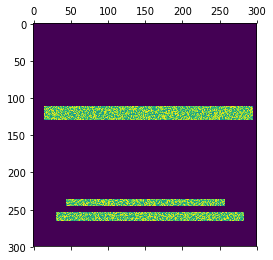

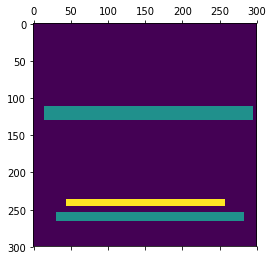

In [27]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

# MAX_WIDTH = 40
# MAX_HEIGHT = 60
# MAX_NUM_REGIONS = 6
# MIN_REGION_WIDTH = 30
# MAX_REGION_WIDTH = 40
# MIN_REGION_HEIGHT = 5
# MAX_REGION_HEIGHT = 10

MAX_WIDTH = 300
MAX_HEIGHT = 300
MAX_NUM_REGIONS = 9
MIN_REGION_WIDTH = 200
MAX_REGION_WIDTH = 280
MIN_REGION_HEIGHT = 10
MAX_REGION_HEIGHT = 20
    
    
def generate_regions(num_regions):
    regions = []
    min_height = 0
    for ind in range(num_regions):
        region_height = np.random.randint(MIN_REGION_HEIGHT, MAX_REGION_HEIGHT)
        try:
            y1 = np.random.randint(min_height, MAX_HEIGHT - region_height)
            y2 = y1 + region_height
            width = np.random.randint(MIN_REGION_WIDTH, MAX_REGION_WIDTH)
            x1 = np.random.randint(0, MAX_WIDTH - width)
            x2 = x1 + width
        except:
            return False
        regions.append((y1, y2, x1, x2))
        min_height = y2
    return regions


def generate_input_and_gt():
    gt_image = np.zeros((MAX_HEIGHT, MAX_WIDTH), dtype=np.uint8)
    num_regions = np.random.randint(MAX_NUM_REGIONS) + 1
    regions = generate_regions(num_regions)
    while not regions:
        regions = generate_regions(num_regions)
    for ind, region in enumerate(regions):
        y1, y2, x1, x2 = region
        gt_image[y1:y2, x1:x2] = ind % 2 + 1
#         gt_image[y1:y2, x1:x2] = ind + 1
    input_image = (255 * (gt_image > 0) * (0.5 + 0.5 * np.random.rand(MAX_HEIGHT, MAX_WIDTH)))
    return input_image.astype(np.uint8), gt_image.astype(np.uint8)
    
    
input_image, gt_image = generate_input_and_gt()
print(input_image.shape, input_image.dtype, gt_image.shape, gt_image.dtype)
plt.figure()
plt.matshow(input_image, vmin=0, vmax=255)
plt.matshow(gt_image)

In [28]:
from tensorflow.keras.utils import to_categorical

BATCH_SIZE = 64
NUM_BATCHES = 1

NUM_LABELS = 3
# NUM_LABELS = MAX_NUM_REGIONS + 1

X = []
Y = []
for _ in range(BATCH_SIZE * NUM_BATCHES):
    if len(X) % 10 == 0:
        print(f'On {len(X)}/{BATCH_SIZE * NUM_BATCHES}')
    input_image, gt_image = generate_input_and_gt()
    X.append(input_image / 255)
    Y.append(to_categorical(gt_image.flatten(), NUM_LABELS))
X = np.array(X).astype(np.float32)
Y = np.array(Y).astype(np.uint8)
print(X.shape, X.dtype, Y.shape, Y.dtype)

On 0/64
On 10/64
On 20/64
On 30/64
On 40/64
On 50/64
On 60/64
(64, 300, 300) float32 (64, 90000, 3) uint8


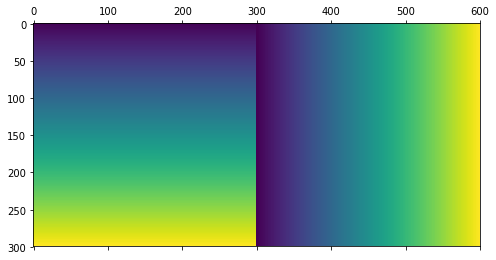

In [29]:
height_map = np.ones((MAX_HEIGHT, MAX_WIDTH))
height = np.arange(MAX_HEIGHT) / MAX_HEIGHT
height_map = height_map * np.expand_dims(height, 1)

width_map = np.ones((MAX_HEIGHT, MAX_WIDTH))
width = np.arange(MAX_WIDTH) / MAX_WIDTH
width_map = width_map * np.expand_dims(width, 0)

plt.matshow(np.hstack([height_map, width_map]))

height_map = height_map.reshape((1, MAX_HEIGHT, MAX_WIDTH, 1))
width_map = width_map.reshape((1, MAX_HEIGHT, MAX_WIDTH, 1))

In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Add, Concatenate, Conv2D, Dense, Flatten, Input, Lambda, LSTM, MaxPooling2D, Reshape
from tensorflow.keras import backend as K
import tensorflow as tf

KERNEL_SIZE = 5
DILATION_RATE = 3

height_map = K.variable(height_map)
width_map = K.variable(width_map)

input_image = Input((MAX_HEIGHT, MAX_WIDTH))
input_image_augmented = Lambda(
    lambda x: K.concatenate([
        K.expand_dims(x, -1),
        tf.tile(width_map, (K.shape(x)[0], 1, 1, 1)),
        tf.tile(height_map, (K.shape(x)[0], 1, 1, 1))
    ], axis=-1)
)(input_image)

def prediction_block(image, prediction=None, final_activation='relu'):
    if prediction is not None:
        image = Concatenate()([image, prediction])
    conv1 = Conv2D(64, kernel_size=KERNEL_SIZE, dilation_rate=DILATION_RATE, padding='same', activation='relu')(image)
    conv2 = Conv2D(32, kernel_size=KERNEL_SIZE, dilation_rate=DILATION_RATE, padding='same', activation='relu')(conv1)
    conv3 = Conv2D(NUM_LABELS, kernel_size=KERNEL_SIZE, dilation_rate=DILATION_RATE, padding='same', activation=final_activation)(conv2)
    # Useful calculator: https://fomoro.com/projects/project/receptive-field-calculator
    return conv3

prediction = prediction_block(input_image_augmented)
prediction = prediction_block(input_image_augmented, prediction)
prediction = prediction_block(input_image_augmented, prediction)
prediction = prediction_block(input_image_augmented, prediction, 'softmax')

output = Reshape((MAX_HEIGHT * MAX_WIDTH, NUM_LABELS))(prediction)
model = Model(inputs=input_image, outputs=output)
model.summary()

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
model.fit(x=X, y=Y, epochs=32, batch_size=16, validation_split=0.2)

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 300, 300)     0                                            
__________________________________________________________________________________________________
lambda_5 (Lambda)               (None, 300, 300, 3)  0           input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_60 (Conv2D)              (None, 300, 300, 64) 4864        lambda_5[0][0]                   
__________________________________________________________________________________________________
conv2d_61 (Conv2D)              (None, 300, 300, 32) 51232       conv2d_60[0][0]                  
__________________________________________________________________________________________________
conv2d_62 

51/51 [==============================] - 2s 46ms/step - loss: 0.1329 - categorical_accuracy: 0.9145 - val_loss: 0.1113 - val_categorical_accuracy: 0.9300
Epoch 25/32
51/51 [==============================] - 2s 46ms/step - loss: 0.1295 - categorical_accuracy: 0.9178 - val_loss: 0.1087 - val_categorical_accuracy: 0.9289
Epoch 26/32
51/51 [==============================] - 2s 46ms/step - loss: 0.1254 - categorical_accuracy: 0.9187 - val_loss: 0.1085 - val_categorical_accuracy: 0.9253
Epoch 27/32
51/51 [==============================] - 2s 46ms/step - loss: 0.1249 - categorical_accuracy: 0.9230 - val_loss: 0.1090 - val_categorical_accuracy: 0.9315
Epoch 28/32
51/51 [==============================] - 2s 46ms/step - loss: 0.1263 - categorical_accuracy: 0.9179 - val_loss: 0.1086 - val_categorical_accuracy: 0.9334
Epoch 29/32
51/51 [==============================] - 2s 46ms/step - loss: 0.1239 - categorical_accuracy: 0.9209 - val_loss: 0.1081 - val_categorical_accuracy: 0.9266
Epoch 30/32
51/5

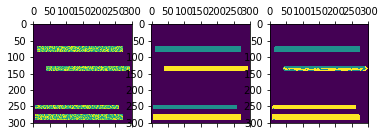

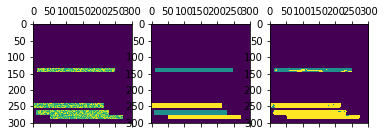

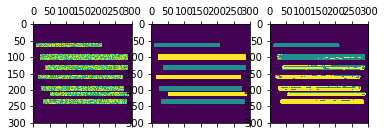

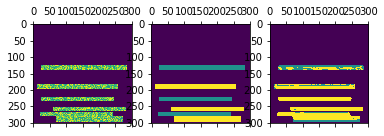

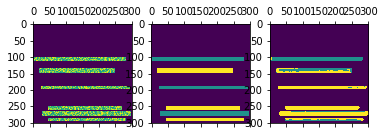

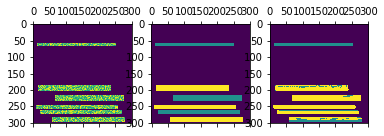

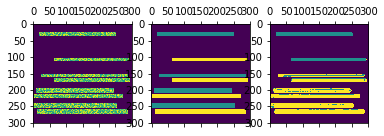

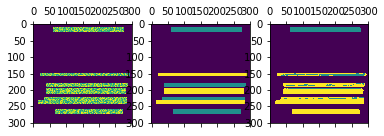

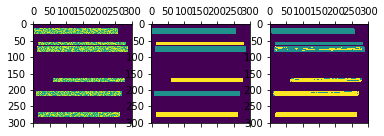

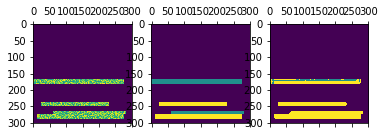

In [31]:
def plot_gt_and_pred(ind):
    sample_input = np.expand_dims(X[ind], 0)
    gt = Y[ind].reshape(MAX_HEIGHT, MAX_WIDTH, -1).argmax(-1)
    pred = model.predict(sample_input).reshape(MAX_HEIGHT, MAX_WIDTH, -1).argmax(-1)
    fig = plt.figure()
    ax1 = fig.add_subplot(131)
    ax1.matshow(X[ind].squeeze())
    ax2 = fig.add_subplot(132)
    ax2.matshow(gt)
    ax3 = fig.add_subplot(133)
    ax3.matshow(pred)
    
for ind in range(10):
    plot_gt_and_pred(ind)